## Import Data


In [32]:
# from google.colab import drive
# drive.mount('/content/drive')

In [33]:
import pandas as pd
data = pd.read_csv("DukuhKupang.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40043 entries, 0 to 40042
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timezone                  40043 non-null  object 
 1   Datetime                  40043 non-null  object 
 2   AQI US                    40043 non-null  int64  
 3   AQI CN                    40043 non-null  int64  
 4   PM2.5 (ug/m3)             40043 non-null  float64
 5   PM10 (ug/m3)              40043 non-null  int64  
 6   CO2 (ppm)                 40043 non-null  int64  
 7   Temperature (Celsius)     40043 non-null  float64
 8   Temperature (Fahrenheit)  40043 non-null  float64
 9   Humidity (%)              40043 non-null  int64  
 10  HCHO (ppb)                0 non-null      float64
 11  TVOC (ppb)                0 non-null      float64
dtypes: float64(5), int64(5), object(2)
memory usage: 3.7+ MB


In [34]:
drop_cols = ['Datetime','Timezone','AQI CN','AQI US','HCHO (ppb)','TVOC (ppb)','Temperature (Fahrenheit)','Temperature (Celsius)']
data = data.drop(columns=drop_cols)

In [35]:
print("Missing values:\n", data.isnull().sum())
print("\nDuplicated rows:", data.duplicated().sum())

Missing values:
 PM2.5 (ug/m3)    0
PM10 (ug/m3)     0
CO2 (ppm)        0
Humidity (%)     0
dtype: int64

Duplicated rows: 1630


In [36]:
data.duplicated().sum()

1630

In [37]:
# Hapus NA & duplicate
data = data.dropna().drop_duplicates()
print("Shape setelah pembersihan:", data.shape)

# %%
# Statistik deskriptif
display(data.describe())

Shape setelah pembersihan: (38413, 4)


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Humidity (%)
count,38413.000000,38413.000000,38413.000000,38413.000000
mean,39.952459,77.260459,430.852394,79.624346
std,34.019731,67.882553,21.461646,12.608268
min,3.000000,3.000000,390.000000,41.000000
25%,19.000000,36.000000,416.000000,72.000000
50%,30.000000,57.000000,426.000000,83.000000
75%,50.000000,93.000000,440.000000,90.000000
max,1798.800000,2000.000000,628.000000,97.000000


In [38]:
## cek data Oulier

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_indices = data[(data < lower_bound) | (data > upper_bound)].dropna(how='all').index
print(f"Number of potential outliers detected: {len(outlier_indices)}")

Number of potential outliers detected: 3980


In [39]:
## Hapus data Oulier
data_cleaned_looped = data.copy() # Create a copy to avoid modifying the original data

while True:
    Q1 = data_cleaned_looped.quantile(0.25)
    Q3 = data_cleaned_looped.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_indices = data_cleaned_looped[(data_cleaned_looped < lower_bound) | (data_cleaned_looped > upper_bound)].dropna(how='all').index

    if len(outlier_indices) == 0:
        print("No more outliers detected.")
        break
    else:
        print(f"Removing {len(outlier_indices)} potential outliers.")
        data_cleaned_looped = data_cleaned_looped.drop(outlier_indices)

print(f"Number of rows after removing outliers iteratively: {len(data_cleaned_looped)}")
display(data_cleaned_looped.head())

Removing 3980 potential outliers.
Removing 2084 potential outliers.
Removing 1136 potential outliers.
Removing 471 potential outliers.
Removing 148 potential outliers.
Removing 129 potential outliers.
Removing 89 potential outliers.
Removing 281 potential outliers.
No more outliers detected.
Number of rows after removing outliers iteratively: 30095


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Humidity (%)
0,21.0,35,430,47
1,17.0,37,430,46
2,19.0,32,428,46
3,18.0,31,428,47
4,19.0,40,427,47


In [40]:
data_cleaned_looped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30095 entries, 0 to 40042
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM2.5 (ug/m3)  30095 non-null  float64
 1   PM10 (ug/m3)   30095 non-null  int64  
 2   CO2 (ppm)      30095 non-null  int64  
 3   Humidity (%)   30095 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.1 MB


<Axes: >

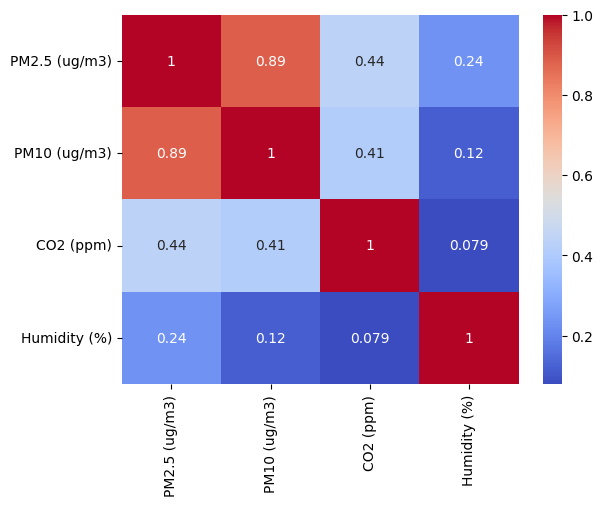

In [41]:
## Heatmap Data
import seaborn as sns
sns.heatmap(data_cleaned_looped.corr(), annot=True, cmap='coolwarm')

# Prepocessing

In [42]:
from sklearn.model_selection import train_test_split

# Asumsikan data_cleaned_looped adalah data numerik yang sudah dibersihkan
X = data_cleaned_looped.copy()

# Split sebelum apa pun!
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, stratify=None)

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # FIT HANYA DI SINI
X_test_scaled = scaler.transform(X_test)         # HANYA TRANSFORM, TIDAK FIT

In [44]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# Range jumlah cluster yang diuji
cluster_range = range(2, 11)  # bisa diatur sesuai kebutuhan

silhouette_scores = {}

# Loop dengan tqdm
for n_clusters in tqdm(cluster_range, desc="Evaluating clusters", unit="cluster"):
    ahc = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = ahc.fit_predict(X_train_scaled)
    score = silhouette_score(X_train_scaled, labels)
    print(f"n_cluster = {n_clusters} Silhouette Score = {score}")
    silhouette_scores[n_clusters] = score

# Cari jumlah cluster optimal
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)

print("\n--- Analisis Silhouette Score ---")
for n, score in silhouette_scores.items():
    print(f"Jumlah cluster {n}: Silhouette Score = {score:.4f}")

print(f"\nJumlah cluster optimal berdasarkan Silhouette Score: {optimal_clusters}")


Evaluating clusters:  11%|█         | 1/9 [00:15<02:02, 15.25s/cluster]

n_cluster = 2 Silhouette Score = 0.323191611934921


Evaluating clusters:  22%|██▏       | 2/9 [00:26<01:31, 13.14s/cluster]

n_cluster = 3 Silhouette Score = 0.2630927569172359


Evaluating clusters:  33%|███▎      | 3/9 [00:39<01:18, 13.10s/cluster]

n_cluster = 4 Silhouette Score = 0.21214347889460722


Evaluating clusters:  44%|████▍     | 4/9 [00:51<01:01, 12.32s/cluster]

n_cluster = 5 Silhouette Score = 0.18416315133761468


Evaluating clusters:  56%|█████▌    | 5/9 [01:02<00:48, 12.06s/cluster]

n_cluster = 6 Silhouette Score = 0.1883677349328131


Evaluating clusters:  67%|██████▋   | 6/9 [01:15<00:37, 12.38s/cluster]

n_cluster = 7 Silhouette Score = 0.17380466753925858


Evaluating clusters:  78%|███████▊  | 7/9 [01:26<00:23, 11.93s/cluster]

n_cluster = 8 Silhouette Score = 0.1753351893560442


Evaluating clusters:  89%|████████▉ | 8/9 [01:37<00:11, 11.66s/cluster]

n_cluster = 9 Silhouette Score = 0.16641354190630553


Evaluating clusters: 100%|██████████| 9/9 [01:48<00:00, 12.11s/cluster]

n_cluster = 10 Silhouette Score = 0.1759042486016281

--- Analisis Silhouette Score ---
Jumlah cluster 2: Silhouette Score = 0.3232
Jumlah cluster 3: Silhouette Score = 0.2631
Jumlah cluster 4: Silhouette Score = 0.2121
Jumlah cluster 5: Silhouette Score = 0.1842
Jumlah cluster 6: Silhouette Score = 0.1884
Jumlah cluster 7: Silhouette Score = 0.1738
Jumlah cluster 8: Silhouette Score = 0.1753
Jumlah cluster 9: Silhouette Score = 0.1664
Jumlah cluster 10: Silhouette Score = 0.1759

Jumlah cluster optimal berdasarkan Silhouette Score: 2


Silhouette Score: 0.3232
Davies-Bouldin Index: 1.1946


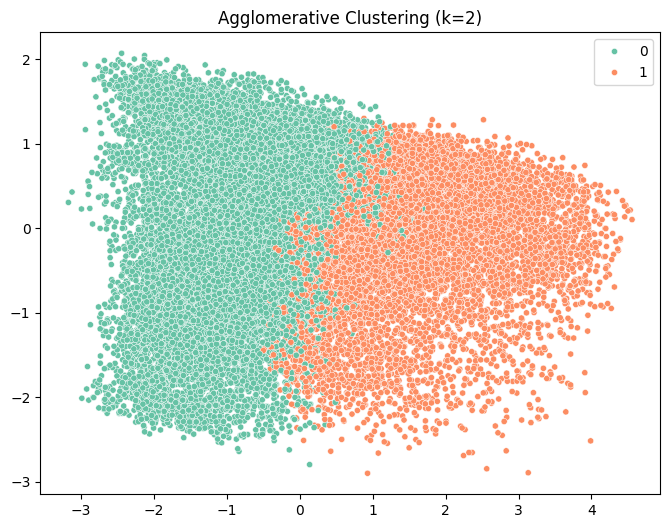

             PM2.5 (ug/m3)  PM10 (ug/m3)   CO2 (ppm)  Humidity (%)
Cluster_AHC                                                       
0                20.445827     38.540850  418.214429     77.243967
1                42.585644     79.370039  432.782705     79.538829


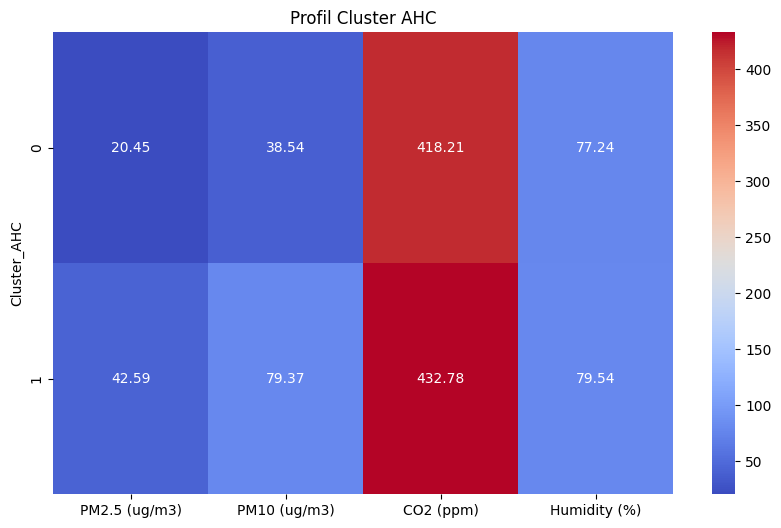

In [45]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit dengan jumlah cluster optimal
ahc_optimal = AgglomerativeClustering(n_clusters=optimal_clusters, linkage="ward")
ahc_labels = ahc_optimal.fit_predict(X_train_scaled)

# Evaluasi
sil_score = silhouette_score(X_train_scaled, ahc_labels)
dbi_score = davies_bouldin_score(X_train_scaled, ahc_labels)
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

# %%
# Visualisasi PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=ahc_labels, palette="Set2", s=20)
plt.title(f"Agglomerative Clustering (k={optimal_clusters})")
plt.show()

# %%
# Profil cluster
X_train["Cluster_AHC"] = ahc_labels
cluster_profile = X_train.groupby("Cluster_AHC").mean()
print(cluster_profile)

plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Profil Cluster AHC")
plt.show()

In [ ]:
# --- Fungsi AQI ---
import numpy as np

# Tabel breakpoints (Bmin, Bmax, Imin, Imax)
breakpoints = {
    "PM2.5": [(0, 30, 0, 50),
              (31, 60, 51, 100),
              (61, 90, 101, 200),
              (91, 120, 201, 300),
              (121, 250, 301, 400)],
    
    "PM10": [(0, 50, 0, 50),
             (51, 100, 51, 100),
             (101, 250, 101, 200),
             (251, 350, 201, 300),
             (351, 430, 301, 400)],
    
    # Sementara pakai kategori CO (mg/m3) diadaptasi ke ppm (contoh kasar)
    "CO2": [(0, 1000, 0, 50),
            (1001, 2000, 51, 100),
            (2001, 5000, 101, 200),
            (5001, 10000, 201, 300),
            (10001, 20000, 301, 400)]
}

def calculate_sub_index(pollutant, concentration):
    for (Bmin, Bmax, Imin, Imax) in breakpoints[pollutant]:
        if Bmin <= concentration <= Bmax:
            return ((Imax - Imin) / (Bmax - Bmin)) * (concentration - Bmin) + Imin
    return np.nan
def calculate_aqi_linear(row):
    sub_pm25 = calculate_sub_index("PM2.5", row["PM2.5 (ug/m3)"])
    sub_pm10 = calculate_sub_index("PM10", row["PM10 (ug/m3)"])
    sub_co2  = calculate_sub_index("CO2", row["CO2 (ppm)"])
    
    return max(sub_pm25, sub_pm10, sub_co2)

def categorize_aqi(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"
    
X_train["AQI_Value"] = X_train.apply(calculate_aqi_linear, axis=1)
X_train["AQI_Category"] = X_train["AQI_Value"].apply(categorize_aqi)



AQI_Category   Good  Moderate  Satisfactory  Severe
Cluster_AHC                                        
0             11963         9          3940       0
1               200      1442          6422     100


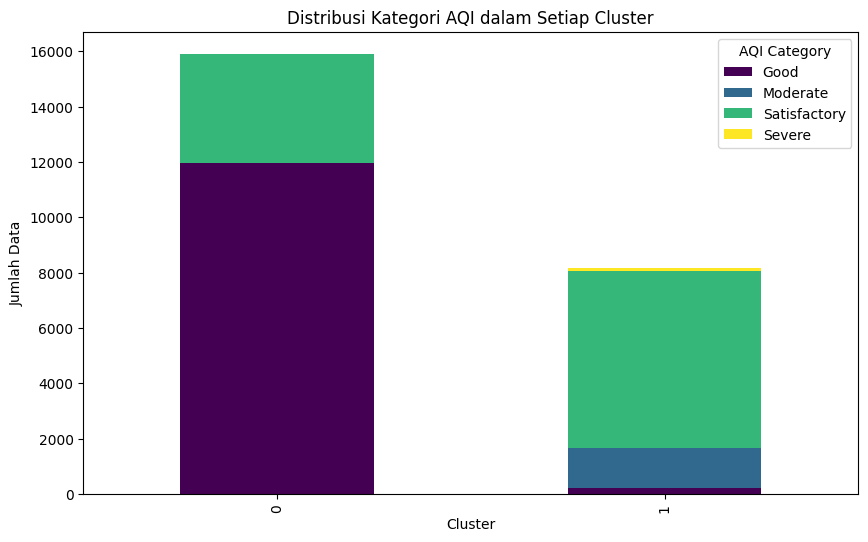

In [47]:
# Crosstab cluster vs AQI Category
cluster_summary = pd.crosstab(X_train["Cluster_AHC"], X_train["AQI_Category"])
print(cluster_summary)

# Plot stacked bar
cluster_summary.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribusi Kategori AQI dalam Setiap Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.legend(title="AQI Category")
plt.show()
